In [1]:
%load_ext autoreload
%autoreload 2

import sys,os
import torch
import yaml
import logging
import pytorch_lightning as pl
from pydantic import ValidationError

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd()))))))
from datasets.weather_bench import WeatherDataset
from models.CiT.datasets.dataset import ValidationDataset
from models.CiT.training.configs import TrainingConfig
from models.CiT.training.configs import TrainingRunConfig

def get_normal_dataset(config: TrainingConfig):
    device = ("cuda" if torch.cuda.is_available() else "cpu" )
    device = torch.device(device)

    vars = config.air_variable + config.surface_variable + config.only_input_variable + config.constant_variable

    weather = WeatherDataset(config.train_start, config.train_end, device=device, download_variables=vars, download_levels=config.levels)
    # dataset.shape:  torch.Size([7309, 100, 1450])
    
    source, mean_std, var_vocab = weather.load_one(config.air_variable, config.surface_variable, config.only_input_variable, 
                                        config.constant_variable, level=config.levels)
    
    var_list = var_vocab.get_code(vars)
    print(var_list)
    dataset = ValidationDataset(source, var_list, config.time_len, config.max_lead_time)
    return dataset, mean_std, var_list

config_path = os.path.join(os.path.dirname(os.getcwd()), 'configs/train_config.yaml')

try:
    with open(config_path) as f:
        config_dict = yaml.safe_load(f)
    config: TrainingRunConfig = TrainingRunConfig.parse_obj(config_dict)
except FileNotFoundError:
    logging.error(f"Config file {config_path} does not exist. Exiting.")
except yaml.YAMLError:
    logging.error(f"Config file {config_path} is not valid YAML. Exiting.")
except ValidationError as e:
    logging.error(f"Config file {config_path} is not valid. Exiting.\n{e}")
else:
    pl.seed_everything(config.seed)


dataset, mean_std, var_list = get_normal_dataset(config.training)

Seed set to 123


데이터셋 불러오는 중...
2013-01-01T00:00:00.000000000
2023-01-01T00:00:00.000000000
==== LOAD DATASET ====
 <xarray.Dataset>
Dimensions:                  (time: 87649, latitude: 36, longitude: 36, level: 8)
Coordinates:
  * latitude                 (latitude) float64 20.04 20.74 ... 43.95 44.65
  * level                    (level) int64 50 100 250 500 600 700 850 925
  * longitude                (longitude) float64 115.3 116.0 ... 139.2 139.9
  * time                     (time) datetime64[ns] 2013-01-01 ... 2023-01-01
Data variables:
    10m_u_component_of_wind  (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    10m_v_component_of_wind  (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    2m_temperature           (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    geopotential             (time, level, latitude, longitude) float32 dask.array<chunksize=(256, 8, 36, 36), meta

100%|██████████| 12/12 [00:34<00:00,  2.86s/it]


40.07637 sec
tensor([ 0,  1,  2,  3,  4,  5,  6,  7, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 58, 56, 57, 61, 63, 64])


In [2]:
%load_ext autoreload
%autoreload 2

from models.CiT.training.lightning import TrainModule

model = TrainModule.load_from_checkpoint('/workspace/Haea_dev/models/CiT/tb_logs/lightning_logs/m41ddj8k/checkpoints/epoch=12-step=56966.ckpt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/workspace/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [3]:
from torch.utils.data import DataLoader, Dataset
import tqdm

test_ds, _ = torch.utils.data.random_split(
            dataset,
            [0.3, 0.7],
        )

data_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=4)
results = []
epoch = 1
model.setting()

for i, batch in enumerate(tqdm.tqdm(data_loader)):
        result = model(batch)
        results.append(result)

  0%|          | 0/1095 [00:00<?, ?it/s]

100%|██████████| 1095/1095 [04:18<00:00,  4.23it/s]


In [4]:
errors = []
p_preds = []
p_labels = []
for loss, p_pred, p_label in results:
    errors.append(loss)
    p_preds.append(p_pred)
    p_labels.append(p_label)

In [5]:
errors = torch.stack(errors, dim=0)
print(errors.shape)
p_preds = torch.stack(p_preds, dim=0)
print(p_preds.shape)
p_labels = torch.stack(p_labels, dim=0)
print(p_labels.shape)

torch.Size([1095, 3, 24, 54])
torch.Size([1095, 3, 24])
torch.Size([1095, 3, 24])


In [6]:
p_preds = p_preds.view(p_preds.size(0), -1)
p_labels = p_labels.view(p_labels.size(0), -1)

In [16]:
print(p_preds)

tensor([[0.4936, 0.4933, 0.4925,  ..., 0.6741, 0.6350, 0.6031],
        [0.1294, 0.1367, 0.1396,  ..., 0.1571, 0.1425, 0.1459],
        [0.3112, 0.3284, 0.3421,  ..., 0.5079, 0.4696, 0.4584],
        ...,
        [0.1844, 0.1930, 0.1920,  ..., 0.2060, 0.2091, 0.2249],
        [0.0149, 0.0167, 0.0223,  ..., 0.1278, 0.1291, 0.1270],
        [0.0773, 0.0732, 0.0676,  ..., 0.1146, 0.1186, 0.1347]],
       device='cuda:0')


In [9]:
p_threshold = 0.1
  
p_h = torch.sum(torch.logical_and((p_labels >= p_threshold), (p_preds >= p_threshold)), dim=0) # 강수 맞힘
p_m = torch.sum(torch.logical_and((p_labels >= p_threshold), (p_preds < p_threshold)), dim=0) # 강수 놓침
p_f = torch.sum(torch.logical_and((p_labels < p_threshold), (p_preds >= p_threshold)), dim=0)  # 강수 틀림
p_c = torch.sum(torch.logical_and((p_labels < p_threshold), (p_preds < p_threshold)), dim=0) # 강수 없음 맞힘

acc = ((p_h + p_c) / (p_h + p_m + p_f + p_c))
pod = p_h / (p_h + p_m)

In [10]:
print(acc)
print(pod)

tensor([0.9479, 0.9507, 0.9571, 0.9507, 0.9452, 0.9571, 0.9507, 0.9470, 0.9416,
        0.9397, 0.9361, 0.9370, 0.9342, 0.9242, 0.9260, 0.9388, 0.9397, 0.9406,
        0.9352, 0.9397, 0.9379, 0.9352, 0.9279, 0.9379, 0.9470, 0.9516, 0.9443,
        0.9397, 0.9297, 0.9361, 0.9406, 0.9361, 0.9352, 0.9397, 0.9416, 0.9361,
        0.9352, 0.9306, 0.9297, 0.9288, 0.9425, 0.9443, 0.9461, 0.9553, 0.9489,
        0.9507, 0.9489, 0.9479, 0.6575, 0.6384, 0.6274, 0.6265, 0.6338, 0.6484,
        0.6548, 0.6584, 0.6502, 0.6466, 0.6283, 0.6247, 0.6110, 0.6119, 0.6201,
        0.6210, 0.6429, 0.6566, 0.6740, 0.6740, 0.6685, 0.6712, 0.6721, 0.6594],
       device='cuda:0')
tensor([0.9509, 0.9614, 0.9785, 0.9815, 0.9726, 0.9702, 0.9606, 0.9640, 0.9605,
        0.9529, 0.9544, 0.9540, 0.9560, 0.9608, 0.9569, 0.9674, 0.9517, 0.9488,
        0.9373, 0.9593, 0.9527, 0.9480, 0.9414, 0.9497, 0.9521, 0.9615, 0.9736,
        0.9732, 0.9647, 0.9608, 0.9557, 0.9655, 0.9631, 0.9602, 0.9701, 0.9712,
        0.9696,

In [11]:
errors = errors.mean(dim=0)
print(errors.shape)

torch.Size([3, 24, 54])


In [12]:
errors = errors.view(-1, errors.size(-1))
print(errors.shape)

torch.Size([72, 54])


In [13]:
output = errors.swapaxes(0, 1)

print(output.shape)

torch.Size([54, 72])


In [14]:
import matplotlib.pyplot as plt

def visualize(loss: torch.Tensor, title, isAIR = False, level=None):
    loss = loss.cpu()
    if isAIR:
        loss = loss.swapaxes(0, 1)
        if level is not None:
            loss = loss[:, level]
        
    print(loss.shape)
    plt.plot(loss, label="rmse loss")
    plt.title(title)
    plt.show()

torch.Size([72])


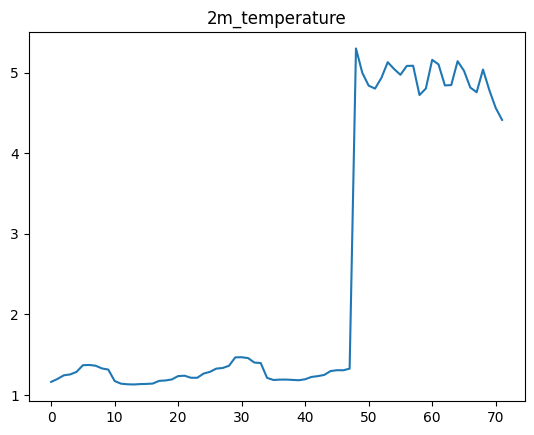

torch.Size([72])


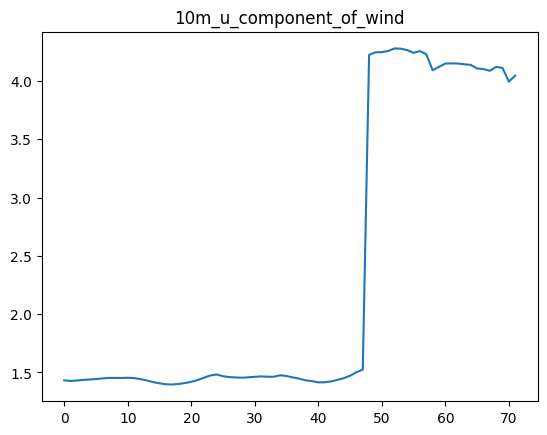

torch.Size([72])


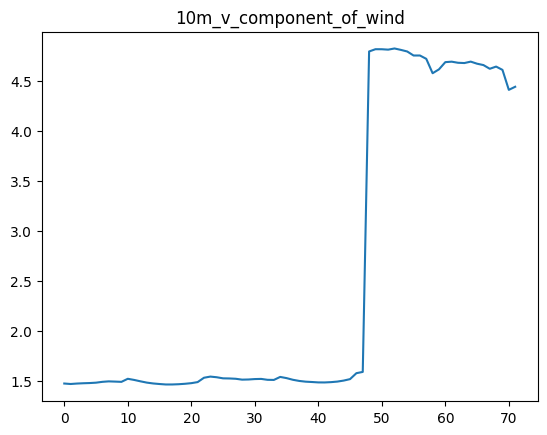

torch.Size([72])


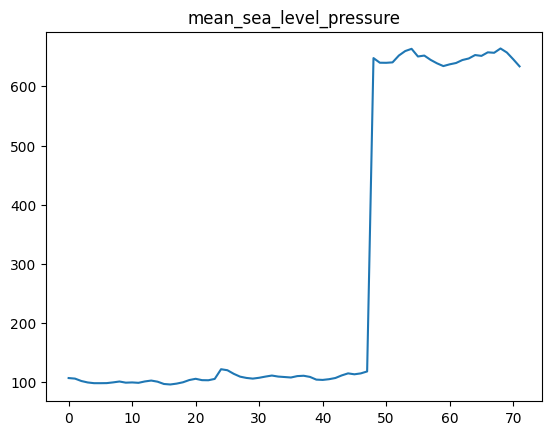

torch.Size([72])


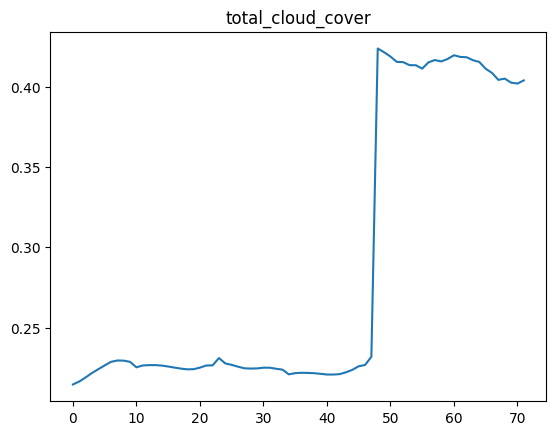

torch.Size([72])


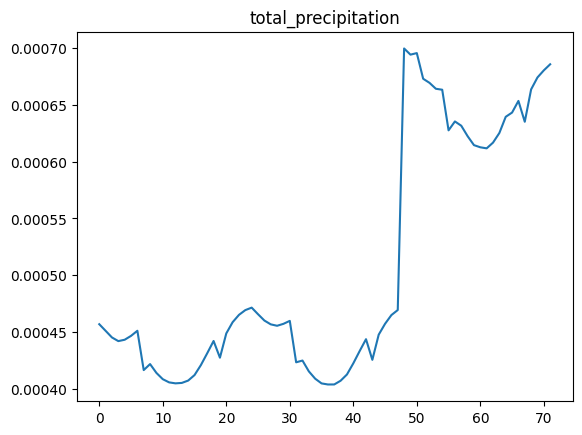

In [15]:
for i, var in enumerate(config.training.surface_variable):
        idx = len(config.training.air_variable) * len(config.training.levels) + i
        visualize(torch.sqrt(output[idx]), var, isAIR=False)

torch.Size([72])


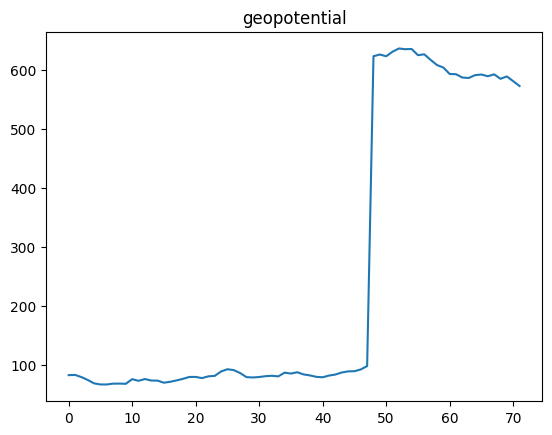

torch.Size([72])


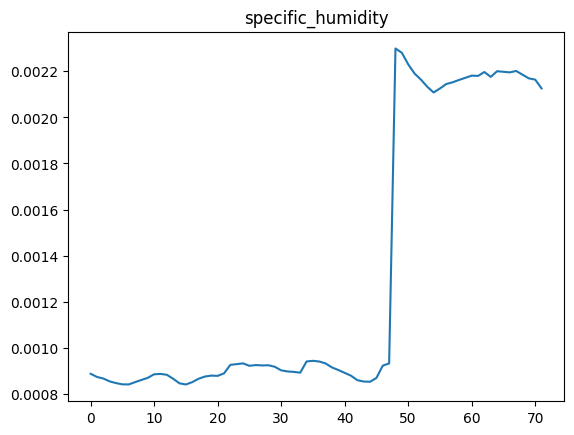

torch.Size([72])


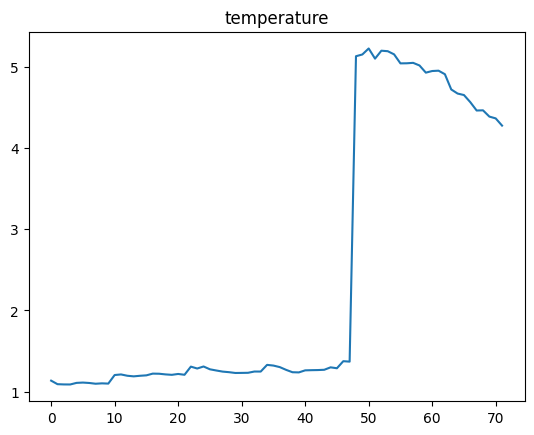

torch.Size([72])


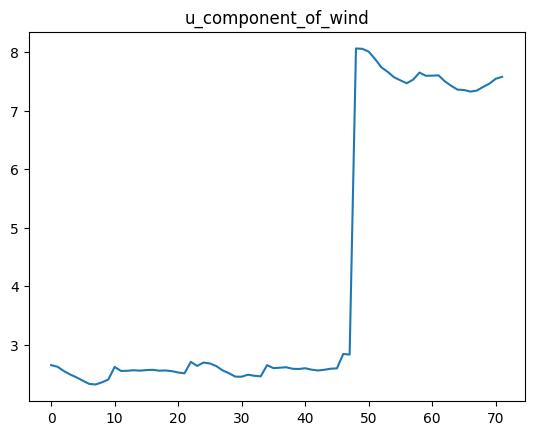

torch.Size([72])


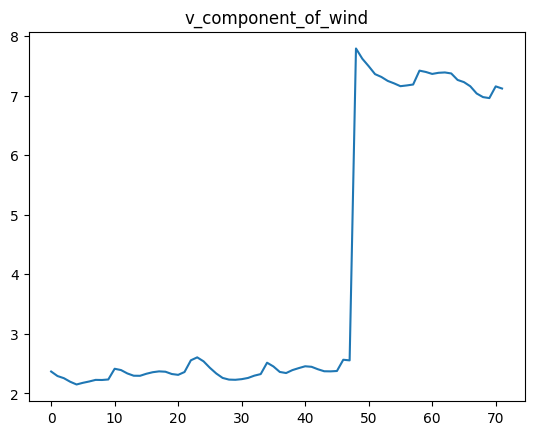

torch.Size([72])


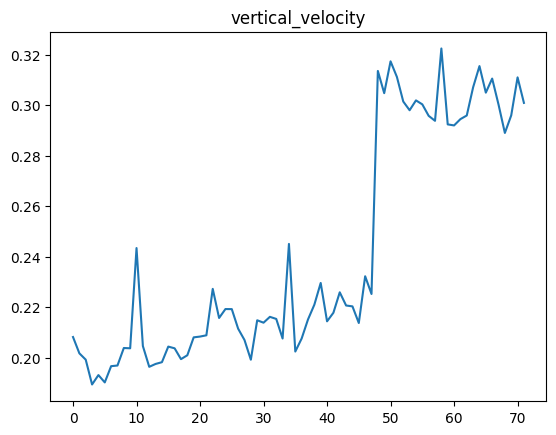

In [11]:
for idx, var in enumerate(config.training.air_variable):
        air_list = [ ((idx)*len(config.training.levels)) + i for i in range(len(config.training.levels))]
        visualize(torch.sqrt(output[air_list]), var, isAIR=True, level=-3)